# US Census Income Prediction

This notebook outlines the steps to build and evaluate models for predicting whether an individual's income exceeds $50,000 based on US Census data.

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from project import paths
from model_utils import create_if_doesnt_exist
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# List files in data folder

for dirname, _, filenames in os.walk(paths['raw']):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/eviemills/Desktop/dataiku/data/raw/census_income_test.csv
/Users/eviemills/Desktop/dataiku/data/raw/census_income_learn.csv
/Users/eviemills/Desktop/dataiku/data/raw/census_income_metadata.txt


## 1. Data Preprocessing

The data preprocessing steps involve preparing the dataset for modeling, including the following tasks:
- **Adding column names**: Ensure that all columns in the dataset are correctly labeled for better readability and analysis.
- **Label encoding for nominal variables**: Convert categorical features into numerical values so that they can be used in machine learning models.

In [3]:
import re

# Function to extract column names from metadata text
def extract_column_names(metadata):
    # Define a regular expression pattern to match column name lines
    pattern = re.compile(r'^[|]?\s*([A-Za-z0-9\s\(\)-]+)\s*[:\-\s]*')
    
    # Split the metadata by lines
    lines = metadata.splitlines()

    column_names = []
    start_extracting = False

    for line in lines:
        # Try to match the pattern to identify column names
        match = pattern.match(line.strip())
        if match:
            column_name = match.group(1).strip()

            # Start collecting columns when we find 'age' and stop when we reach 'weeks worked in year'
            if column_name.lower() == "age":
                start_extracting = True

            if start_extracting:
                column_names.append(column_name)

            if column_name.lower() == "weeks worked in year":
                break  # Stop after collecting 'weeks worked in year'

    return column_names

# Read metadata from file
file_path = paths['raw'] / 'census_income_metadata.txt'

with open(file_path, 'r') as file:
    metadata = file.read()

# Extract column names starting from 'age' to 'weeks worked in year'
column_names = extract_column_names(metadata)

# Print the extracted column names
for idx, name in enumerate(column_names, 1):
    print(f"{idx}. {name}")

1. age
2. class of worker
3. detailed industry recode
4. detailed occupation recode
5. education
6. wage per hour
7. enroll in edu inst last wk
8. marital stat
9. major industry code
10. major occupation code
11. race
12. hispanic origin
13. sex
14. member of a labor union
15. reason for unemployment
16. full or part time employment stat
17. capital gains
18. capital losses
19. dividends from stocks
20. tax filer stat
21. region of previous residence
22. state of previous residence
23. detailed household and family stat
24. detailed household summary in household
25. instance weight
26. instance weight
27. migration code-change in msa
28. migration code-change in reg
29. migration code-move within reg
30. live in this house 1 year ago
31. migration prev res in sunbelt
32. num persons worked for employer
33. family members under 18
34. country of birth father
35. country of birth mother
36. country of birth self
37. citizenship
38. own business or self employed
39. fill inc questionnair

In [4]:
column_names.remove('instance weight') # included twice for some reason

cols = column_names + ['year', 'TARGET']

In [26]:
learn.shape[0]/test.shape[0]

1.999989976143221

In [5]:
# Read in the learn and test data without using the first row as header
learn = pd.read_csv(paths['raw'] / "census_income_learn.csv", header=None)
test = pd.read_csv(paths['raw'] / "census_income_test.csv", header=None)

# Check if the number of column names matches the number of columns in both datasets

for dataset, name in zip([learn, test], ["learn", "test"]):
    if len(cols) == dataset.shape[1]:
        # Update the DataFrame's column names
        dataset.columns = cols
    else:
        print(f"Warning: The number of extracted column names ({len(cols)}) does not match the number of columns in the {name} data ({dataset.shape[1]})")

# Display the first few rows of the updated DataFrames
print("Learn Data:")
print(learn.head())

print("Test Data:")
print(test.head())

Learn Data:
   age                  class of worker  detailed industry recode  \
0   73                  Not in universe                         0   
1   58   Self-employed-not incorporated                         4   
2   18                  Not in universe                         0   
3    9                  Not in universe                         0   
4   10                  Not in universe                         0   

   detailed occupation recode                    education  wage per hour  \
0                           0         High school graduate              0   
1                          34   Some college but no degree              0   
2                           0                   10th grade              0   
3                           0                     Children              0   
4                           0                     Children              0   

  enroll in edu inst last wk    marital stat           major industry code  \
0            Not in universe    

In [6]:
# Combine data for exploratory analysis

data = pd.concat([learn, test])
print(data.shape) # almost 300,000 records

(299285, 42)


## 2. Model Fitting

The following models are used to predict the target variable (income > $50,000):

### 2a. Fitting an XGBoost Classifier

- Train an **XGBoost Classifier** model to predict income based on the preprocessed dataset.
- Evaluate performance using relevant metrics (e.g., accuracy, AUC, precision, recall).

In [8]:

# change target to numerical
target_map = {' - 50000.':0, ' 50000+.':1}

learn['TARGET'] = learn['TARGET'].map(target_map)
test['TARGET'] = test['TARGET'].map(target_map)

# Define the feature columns (excluding the target column 'TARGET')
X_learn = learn.drop(columns = ['TARGET', 'instance weight'], axis=1)
y_learn = learn['TARGET']

X_test = test.drop(columns = ['TARGET', 'instance weight'], axis=1)
y_test = test['TARGET']

# Encode categorical columns as integers (Label Encoding)
nominal_columns = X_learn.select_dtypes(include=['object']).columns

for col in nominal_columns:
    X_learn[col] = X_learn[col].astype('category').cat.codes
    X_test[col] = X_test[col].astype('category').cat.codes

# Create DMatrix for XGBoost (ensure correct column names)
dtrain = xgb.DMatrix(X_learn, label=y_learn, feature_names=X_learn.columns)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_learn.columns)

# Train the model
params = {'objective': 'binary:logistic', 'eval_metric': 'logloss'}
model = xgb.train(params, dtrain, num_boost_round=100)

# Predict
y_pred = model.predict(dtest)

[16:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[16:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[16:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[16:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned no

In [9]:
# Predict
y_pred = model.predict(dtest)

# Since XGBoost returns probability predictions, you might want to convert them to class labels:
# Threshold the probabilities to get binary predictions (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)  # If probability > 0.5, predict 1, else 0

# Evaluate the model
# Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')

# Log Loss (for probabilistic predictions)
logloss = log_loss(y_test, y_pred)
print(f'Log Loss: {logloss:.4f}')

# Precision, Recall, F1-Score (for binary classification)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average='binary')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc:.4f}')


Accuracy: 0.9557
Log Loss: 0.1156
Precision: 0.7928
Recall: 0.3872
F1 Score: 0.5203
AUC: 0.9522


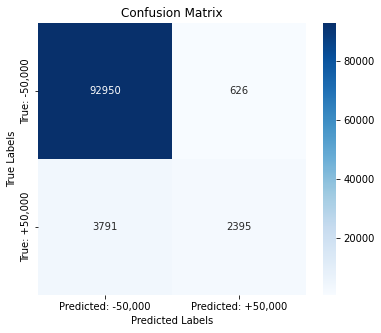

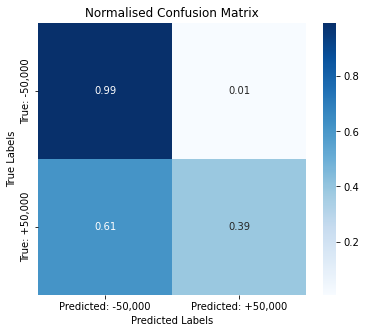

In [10]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Create a Seaborn heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: -50,000', 'Predicted: +50,000'], yticklabels=['True: -50,000', 'True: +50,000'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Normalize confusion matrix by row (i.e., true label)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a Seaborn heatmap to visualize the normalized confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Predicted: -50,000', 'Predicted: +50,000'], yticklabels=['True: -50,000', 'True: +50,000'])
plt.title('Normalised Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

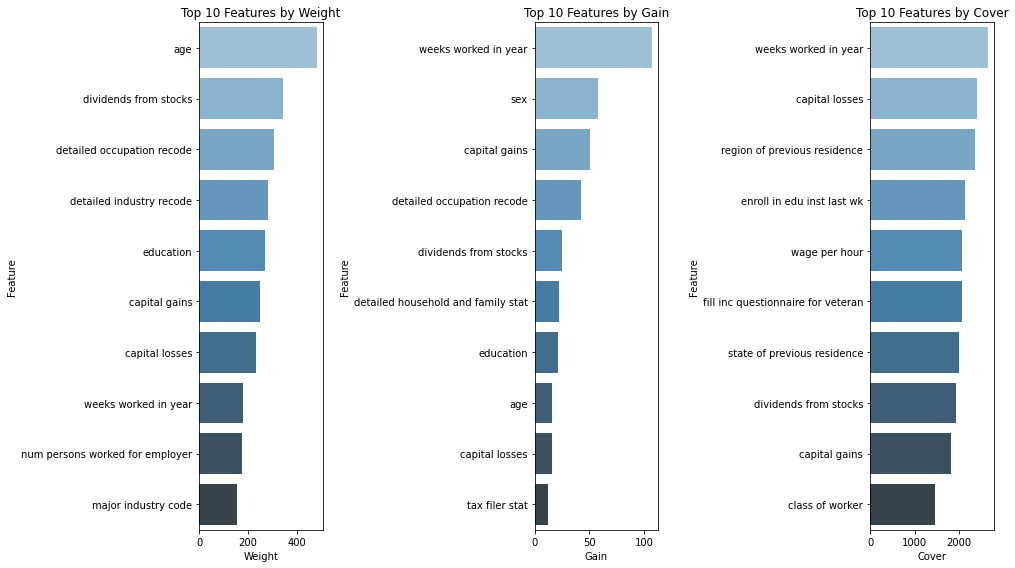

In [11]:
# Get the feature importances using different metrics
importance_weight = model.get_score(importance_type='weight')
importance_gain = model.get_score(importance_type='gain')
importance_cover = model.get_score(importance_type='cover')

# Convert the importances into a DataFrame for easier plotting
importance_df = pd.DataFrame({
    'Feature': list(importance_weight.keys()),
    'Weight': list(importance_weight.values()),
    'Gain': list(importance_gain.values()),
    'Cover': list(importance_cover.values())
})

# Sort each importance metric to get the top 10 features
importance_df_weight = importance_df.sort_values(by='Weight', ascending=False).head(10)
importance_df_gain = importance_df.sort_values(by='Gain', ascending=False).head(10)
importance_df_cover = importance_df.sort_values(by='Cover', ascending=False).head(10)

# Set up the plotting figure
plt.figure(figsize=(14, 8))

# Plot for Weight
plt.subplot(1, 3, 1)
sns.barplot(x='Weight', y='Feature', data=importance_df_weight, palette='Blues_d')
plt.title('Top 10 Features by Weight')

# Plot for Gain
plt.subplot(1, 3, 2)
sns.barplot(x='Gain', y='Feature', data=importance_df_gain, palette='Blues_d')
plt.title('Top 10 Features by Gain')

# Plot for Cover
plt.subplot(1, 3, 3)
sns.barplot(x='Cover', y='Feature', data=importance_df_cover, palette='Blues_d')
plt.title('Top 10 Features by Cover')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### 2b. Fitting an XGBoost Classifier with SMOTE

- **SMOTE (Synthetic Minority Over-sampling Technique)** is applied to handle class imbalance in the dataset.
- Re-train the **XGBoost Classifier** with the SMOTE-synthesized data to improve performance for predicting the minority class (income > $50,000).

In [12]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling the minority class in the training data
smote = SMOTE(sampling_strategy=0.2, random_state=1998)
X_learn_resampled, y_learn_resampled = smote.fit_resample(X_learn, y_learn)

# Create DMatrix for XGBoost (using the resampled data)
dtrain_resampled = xgb.DMatrix(X_learn_resampled, label=y_learn_resampled, feature_names=X_learn.columns)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_learn.columns)

# Train the model with the resampled training data
params = {'objective': 'binary:logistic', 'eval_metric': 'logloss'}
model = xgb.train(params, dtrain_resampled, num_boost_round=100)

# Predict
y_pred = model.predict(dtest)

# Convert probabilities to binary predictions (using a 0.5 threshold)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
# Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')

# Log Loss
logloss = log_loss(y_test, y_pred)
print(f'Log Loss: {logloss:.4f}')

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average='binary')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc:.4f}')

[16:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[16:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[16:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[16:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned no

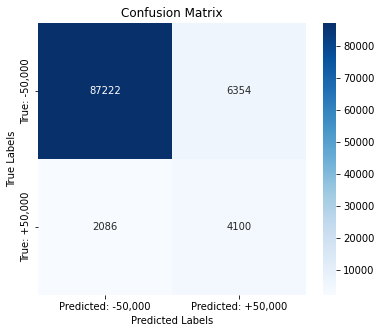

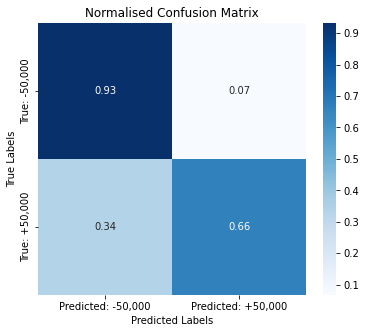

In [13]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Create a Seaborn heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: -50,000', 'Predicted: +50,000'], yticklabels=['True: -50,000', 'True: +50,000'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Normalize confusion matrix by row (i.e., true label)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a Seaborn heatmap to visualize the normalized confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalised, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Predicted: -50,000', 'Predicted: +50,000'], yticklabels=['True: -50,000', 'True: +50,000'])
plt.title('Normalised Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [23]:
importance_df

,Feature,Weight,Gain,Cover
0,weeks worked in year,179,375.106657,2897.529889
1,dividends from stocks,301,59.681240,1963.044482
2,capital gains,216,77.046157,2439.538436
3,capital losses,216,27.594914,2816.762106
4,age,456,44.542765,1574.226810
5,wage per hour,100,17.499472,1974.883315
6,tax filer stat,151,35.182363,1200.271228
7,education,305,81.839054,2094.057542
8,marital stat,109,43.234957,1327.767004
9,detailed household summary in household,49,56.716745,1607.560607


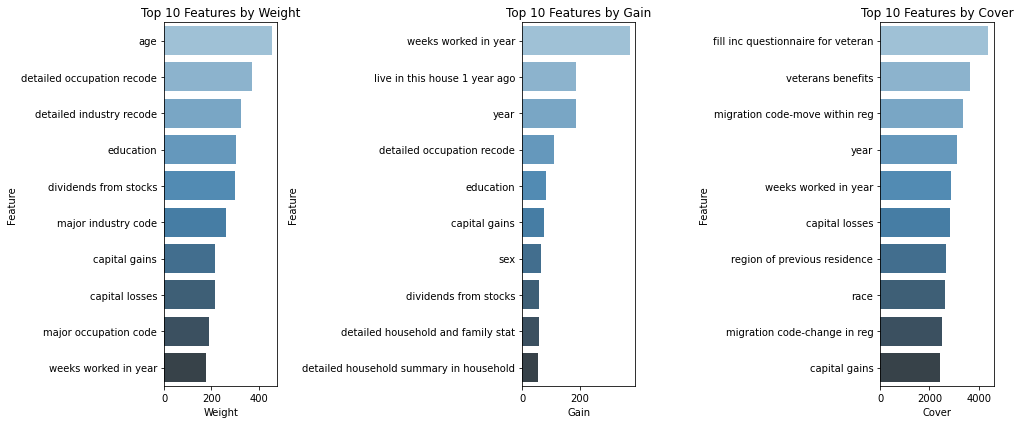

In [14]:
# Get the feature importances using different metrics
importance_weight = model.get_score(importance_type='weight')
importance_gain = model.get_score(importance_type='gain')
importance_cover = model.get_score(importance_type='cover')

# Convert the importances into a DataFrame for easier plotting
importance_df = pd.DataFrame({
    'Feature': list(importance_weight.keys()),
    'Weight': list(importance_weight.values()),
    'Gain': list(importance_gain.values()),
    'Cover': list(importance_cover.values())
})

# Sort each importance metric to get the top 10 features
importance_df_weight = importance_df.sort_values(by='Weight', ascending=False).head(10)
importance_df_gain = importance_df.sort_values(by='Gain', ascending=False).head(10)
importance_df_cover = importance_df.sort_values(by='Cover', ascending=False).head(10)

# Set up the plotting figure
plt.figure(figsize=(14, 6))

# Plot for Weight
plt.subplot(1, 3, 1)
sns.barplot(x='Weight', y='Feature', data=importance_df_weight, palette='Blues_d')
plt.title('Top 10 Features by Weight')

# Plot for Gain
plt.subplot(1, 3, 2)
sns.barplot(x='Gain', y='Feature', data=importance_df_gain, palette='Blues_d')
plt.title('Top 10 Features by Gain')

# Plot for Cover
plt.subplot(1, 3, 3)
sns.barplot(x='Cover', y='Feature', data=importance_df_cover, palette='Blues_d')
plt.title('Top 10 Features by Cover')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### 2c. Fitting a Random Forest Classifier

- Train a **Random Forest Classifier** model to predict income using the preprocessed dataset.
- Evaluate the Random Forest model's performance using relevant metrics (e.g., accuracy, confusion matrix).

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=1998)

# Train the model with the resampled training data
rf_model.fit(X_learn, y_learn)

# Predict on the test set
y_pred = rf_model.predict_proba(X_test)[:, 1]  # Predict probabilities for class 1

# Convert probabilities to binary predictions (using a 0.5 threshold)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
# Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')

# Log Loss (only available with probability predictions)
logloss = log_loss(y_test, y_pred)
print(f'Log Loss: {logloss:.4f}')

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average='binary')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc:.4f}')

Accuracy: 0.9549
Log Loss: 0.1614
Precision: 0.7538
Recall: 0.4054
F1 Score: 0.5273
AUC: 0.9399


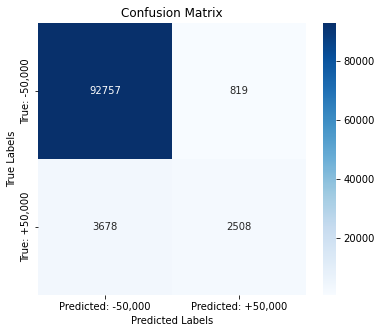

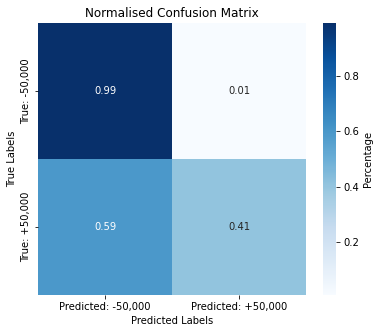

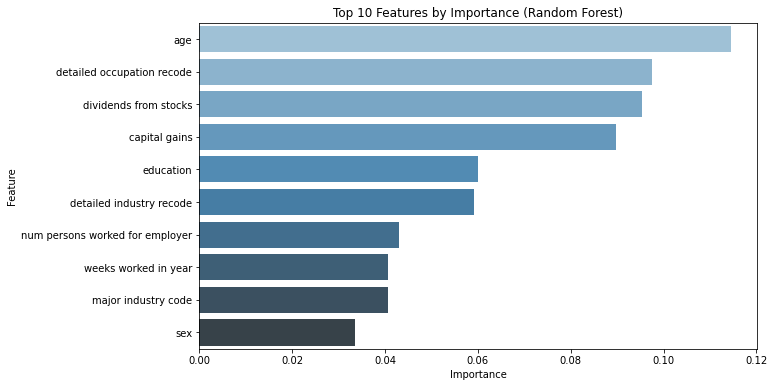

In [16]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: -50,000', 'Predicted: +50,000'], yticklabels=['True: -50,000', 'True: +50,000'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalised, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Predicted: -50,000', 'Predicted: +50,000'], 
            yticklabels=['True: -50,000', 'True: +50,000'], cbar_kws={'label': 'Percentage'})
plt.title('Normalised Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Feature Importances from the Random Forest Model
importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_learn.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features by importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Blues_d')
plt.title('Top 10 Features by Importance (Random Forest)')
plt.show()

### 2d. Fitting a Random Forest Classifier with SMOTE

- Apply **SMOTE** to balance the class distribution.
- Re-train the **Random Forest Classifier** using the SMOTE-generated data to improve predictions for the minority class.

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=1998)

# Train the model with the resampled training data
rf_model.fit(X_learn_resampled, y_learn_resampled)

# Predict on the test set
y_pred = rf_model.predict_proba(X_test)[:, 1]  # Predict probabilities for class 1

# Convert probabilities to binary predictions (using a 0.5 threshold)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
# Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')

# Log Loss (only available with probability predictions)
logloss = log_loss(y_test, y_pred)
print(f'Log Loss: {logloss:.4f}')

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average='binary')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc:.4f}')

Accuracy: 0.9506
Log Loss: 0.1597
Precision: 0.6182
Recall: 0.5310
F1 Score: 0.5713
AUC: 0.9335


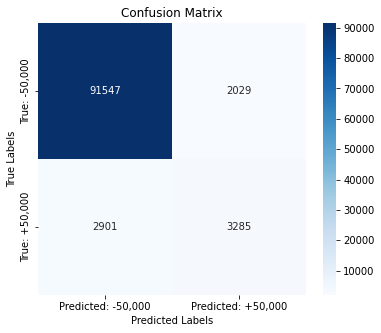

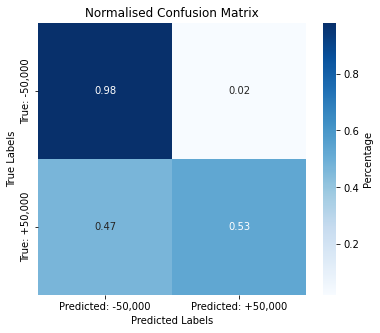

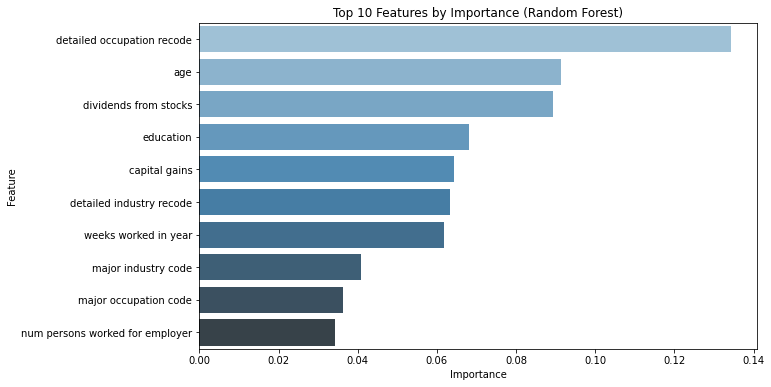

In [18]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: -50,000', 'Predicted: +50,000'], yticklabels=['True: -50,000', 'True: +50,000'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalised, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Predicted: -50,000', 'Predicted: +50,000'], 
            yticklabels=['True: -50,000', 'True: +50,000'], cbar_kws={'label': 'Percentage'})
plt.title('Normalised Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Feature Importances from the Random Forest Model
importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_learn.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features by importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Blues_d')
plt.title('Top 10 Features by Importance (Random Forest)')
plt.show()